# <center> What makes a song a hit? 
    
### <center> Data Science in Practice
   Authors:
    
  

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
pd.set_option('display.max_columns', None)

## Introduction
This is the jupyter notebook containing code used to complete the Data Science in Practice project. 

## Exploratory Data Analysis

### Initial Overview
Before looking for trends and patterns in time and amongst different categories we will first explore what the data looks like

In [2]:
#Importing the finished datasets
df18= pd.read_csv('2018weekconcat.csv')
df19= pd.read_csv('2019weekconcat.csv')
df19_merge = df19.copy()
df19_merge.week = df19_merge.week + df18.week.max()
dfall=pd.concat([df18, df19_merge], ignore_index=True)

In [3]:
dfall.type.value_counts()

audio_features    20800
Name: type, dtype: int64

In [4]:
df18['top'] = np.where(df18['Position']<df18.Position.quantile(0.2), 1, 0)
df19['top'] = np.where(df19['Position']<df19.Position.quantile(0.2), 1, 0)
dfall['top'] = np.where(dfall['Position']<dfall.Position.quantile(0.2), 1, 0)


## Exploring possible time patterns

## Feature Engineering
### Step 1 Feature Selection

In [5]:
dfall_fe = dfall.copy()
dfall_fe = dfall_fe.drop(columns = ['URL', 'uri','track_href','analysis_url','type','Track Name'])

Question: Type?
the number of track name is compariable to the number of songs. 

In [6]:
dfall_fe_id_values = dfall_fe.id.unique().tolist()
cdff = ['counts','index_prev','week_prev','pos_prev','stream_prev']
vdff = np.empty((len(dfall_fe_id_values),len(cdff)))
vdff[:] = np.nan
dfFeature = pd.DataFrame(vdff, 
                         index =dfall_fe_id_values, columns = cdff)

In [7]:
dfall_fe['hist'] = [0]*len(dfall_fe.index)
dfall_fe['new'] = [0]*len(dfall_fe.index)

In [8]:
# Sophie could check
for i in range(dfall_fe.shape[0]):
    if np.isnan(dfFeature.at[dfall_fe.id[i],'counts']):
        dfall_fe.at[i,'new'] = 1
        dfall_fe.at[i,'hist'] = 1
        dfFeature.at[dfall_fe.id[i],'counts'] = 1
        dfall_fe.at[i,'week_prev'] = 0
        dfall_fe.at[i,'stream_prev'] = 0
        dfall_fe.at[i,'pos_prev'] = 200
        
    else:
        dfFeature.at[dfall_fe.id[i],'counts'] += 1
        dfall_fe.at[i,'week_prev'] = dfFeature.at[dfall_fe.id[i],'week_prev']
        dfall_fe.at[i,'stream_prev'] = dfFeature.at[dfall_fe.id[i],'stream_prev']
        dfall_fe.at[i,'pos_prev'] = dfFeature.at[dfall_fe.id[i],'pos_prev']
        dfall_fe.at[i,'hist'] = dfFeature.at[dfall_fe.id[i],'counts']
    dfFeature.at[dfall_fe.id[i],'index_prev'] = i
    dfFeature.at[dfall_fe.id[i],'week_prev'] = dfall_fe.at[i,'week']
    dfFeature.at[dfall_fe.id[i],'stream_prev'] = dfall_fe.at[i,'Streams']
    dfFeature.at[dfall_fe.id[i],'pos_prev'] = dfall_fe.at[i,'Position']

In [9]:
'''
for i in range(100):
    if np.isnan(dfFeature[dfFeature.id == dfall_fe.id[i]].iat[0,0]):
        c = 1
        dfall_fe.at[i,'new'] = 1
    #    dfall_fe.at['hist',i] = 1
    #    dfFeature[dfFeature.id == dfall_fe.id[i]].iat[0,0]
    #else:
    #    dfall_fe.at['hist',i] += 1
    #dfFeature[dfFeature.id == dfall_fe.id[i]].iat[0,1] = i
    '''

"\nfor i in range(100):\n    if np.isnan(dfFeature[dfFeature.id == dfall_fe.id[i]].iat[0,0]):\n        c = 1\n        dfall_fe.at[i,'new'] = 1\n    #    dfall_fe.at['hist',i] = 1\n    #    dfFeature[dfFeature.id == dfall_fe.id[i]].iat[0,0]\n    #else:\n    #    dfall_fe.at['hist',i] += 1\n    #dfFeature[dfFeature.id == dfall_fe.id[i]].iat[0,1] = i\n    "

# Part 2 Feature augmentation

In [10]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo','new','week_prev','pos_prev','stream_prev','duration_ms']    
X_orig = dfall_fe[features]
from sklearn.preprocessing import StandardScaler
x = X_orig.values #returns a numpy array
std_scaler = StandardScaler()
x_scaled = std_scaler.fit_transform(x)

X_scaled = pd.DataFrame(x_scaled, columns = features) 

In [11]:
def generate_polynormial_features_set( parameters ):
    for order in range(2,3):
        features_tmp = features
        for i in range(len(features)):
            features_tmp[i]= features[i]+'_'+str(order)
            x_squared = x_scaled**order
        if order == 2:
            features_poly = 
X_squared = pd.DataFrame(x_squared, columns = features_squared) 

In [12]:
features_sqrt = features
for i in range(len(features)):
    features_sqrt[i]= features[i]+'_sqrt'

x_sqrt = np.sqrt(np.abs(x_scaled))
X_sqrt = pd.DataFrame(x_sqrt, columns = features_sqrt) 

In [13]:
features_sin = features
for i in range(len(features)):
    features_sin[i]= features[i]+'_sin'

x_sin = np.sin(x_scaled)
X_sin = pd.DataFrame(x_sin, columns = features_sin) 

In [14]:
features_cos = features
for i in range(len(features)):
    features_cos[i]= features[i]+'_cos'

x_cos = np.cos(x_scaled)
X_cos = pd.DataFrame(x_cos, columns = features_cos) 

In [236]:
X_combined = pd.concat([X_scaled, X_squared, X_sqrt, X_sin, X_cos], axis=1).reindex(X_scaled.index)

## Modelling 

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix , classification_report
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix,average_precision_score

### Random forest

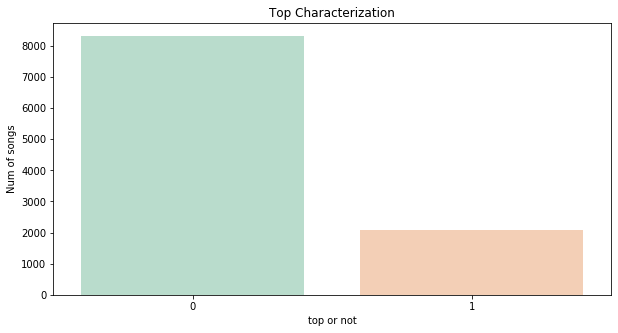

In [11]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df19, x='top',palette="Pastel2")
ax.set(xlabel='top or not', ylabel='Num of songs')
plt.title("Top Characterization")
plt.show()

Accuracy Score: 0.8302884615384616
Recall Score: 0.35336538461538464
Precision Score: 0.6363636363636364


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


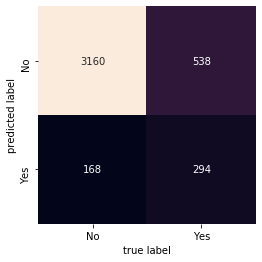

In [12]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo']            
X=dfall[features]
y=dfall['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf= RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.8170673076923077
Recall Score: 0.15985576923076922
Precision Score: 0.6820512820512821


(2.0, 0.0)

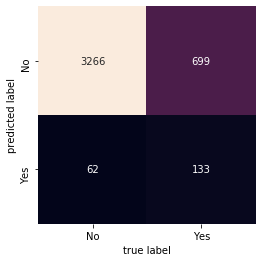

In [13]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo']            
X=dfall[features]
y=dfall['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf = svm.SVC()
clf.fit(X_train, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

### Balancing data set

#### for dfall

df1count  3120
df0count  12480
df1_over  12480


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy Score: 0.6826923076923077
Recall Score: 0.7384615384615385
Precision Score: 0.35787511649580617


(2.0, 0.0)

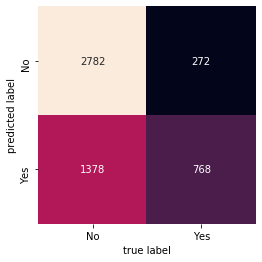

In [14]:
X_train, X_test, y_train, y_test = train_test_split(dfall, dfall["top"], stratify=dfall["top"])
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo']            

# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry svc
clf = svm.SVC()
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

## New section

In [15]:
#number of distinct track name in 2019 200 weekly charts
df19['Track Name'].unique().size

1192

Change data set and consider year as a whole, top meaning song reached top at some point

In [16]:
df19top=df19[df19['top']==1]
df19top['Track Name'].unique().size

353

drop non feature column and then add "top" if at some point during the year the song was popular

In [17]:
df19.head()

,Position,Track Name,Artist,Streams,URL,danceability,energy,key,loudness,mode,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,week,year,top
0,1,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,14202522,https://open.spotify.com/track/3KkXRkHbMCARz0a...,0.760,0.479,2,-5.574,1,...,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4,1,2019,1
1,2,Wow.,Post Malone,12721360,https://open.spotify.com/track/6MWtB6iiXyIwun0...,0.833,0.539,11,-7.399,0,...,audio_features,6MWtB6iiXyIwun0YzU6DFP,spotify:track:6MWtB6iiXyIwun0YzU6DFP,https://api.spotify.com/v1/tracks/6MWtB6iiXyIw...,https://api.spotify.com/v1/audio-analysis/6MWt...,149520,4,1,2019,1
2,3,Going Bad (feat. Drake),Meek Mill,9576466,https://open.spotify.com/track/2IRZnDFmlqMuOrY...,0.889,0.496,4,-6.365,0,...,audio_features,2IRZnDFmlqMuOrYOLnZZyc,spotify:track:2IRZnDFmlqMuOrYOLnZZyc,https://api.spotify.com/v1/tracks/2IRZnDFmlqMu...,https://api.spotify.com/v1/audio-analysis/2IRZ...,180522,4,1,2019,1
3,4,SICKO MODE,Travis Scott,9005380,https://open.spotify.com/track/2xLMifQCjDGFmkH...,0.834,0.730,8,-3.714,1,...,audio_features,2xLMifQCjDGFmkHkpNLD9h,spotify:track:2xLMifQCjDGFmkHkpNLD9h,https://api.spotify.com/v1/tracks/2xLMifQCjDGF...,https://api.spotify.com/v1/audio-analysis/2xLM...,312820,4,1,2019,1
4,5,Drip Too Hard (Lil Baby & Gunna),Lil Baby,8917200,https://open.spotify.com/track/78QR3Wp35dqAhFE...,0.897,0.662,1,-6.903,0,...,audio_features,78QR3Wp35dqAhFEc2qAGjE,spotify:track:78QR3Wp35dqAhFEc2qAGjE,https://api.spotify.com/v1/tracks/78QR3Wp35dqA...,https://api.spotify.com/v1/audio-analysis/78QR...,145543,4,1,2019,1


### New measure of top song
Sort ascending position and keep smallest by dropping ong duplicates. This results in all distinct songs and being top means that at some point it was in the top 20

In [18]:
df19nondup=df19.sort_values('Position', ascending=True).drop_duplicates('Track Name')
df19nondup.index = np.arange(len(df19nondup))
df19nondup.head()

,Position,Track Name,Artist,Streams,URL,danceability,energy,key,loudness,mode,...,type,id,uri,track_href,analysis_url,duration_ms,time_signature,week,year,top
0,1,Sunflower - Spider-Man: Into the Spider-Verse,Post Malone,14202522,https://open.spotify.com/track/3KkXRkHbMCARz0a...,0.760,0.479,2,-5.574,1,...,audio_features,3KkXRkHbMCARz0aVfEt68P,spotify:track:3KkXRkHbMCARz0aVfEt68P,https://api.spotify.com/v1/tracks/3KkXRkHbMCAR...,https://api.spotify.com/v1/audio-analysis/3KkX...,158040,4,1,2019,1
1,1,Señorita,Shawn Mendes,14244170,https://open.spotify.com/track/0TK2YIli7K1leLo...,0.759,0.540,9,-6.039,0,...,audio_features,0TK2YIli7K1leLovkQiNik,spotify:track:0TK2YIli7K1leLovkQiNik,https://api.spotify.com/v1/tracks/0TK2YIli7K1l...,https://api.spotify.com/v1/audio-analysis/0TK2...,190960,4,25,2019,1
2,1,HIGHEST IN THE ROOM,Travis Scott,9395208,https://open.spotify.com/track/3eekarcy7kvN4yt...,0.598,0.427,7,-8.764,0,...,audio_features,3eekarcy7kvN4yt5ZFzltW,spotify:track:3eekarcy7kvN4yt5ZFzltW,https://api.spotify.com/v1/tracks/3eekarcy7kvN...,https://api.spotify.com/v1/audio-analysis/3eek...,175721,4,44,2019,1
3,1,Goodbyes (Feat. Young Thug),Post Malone,14539019,https://open.spotify.com/track/6vBdBCoOhKHiYDD...,0.580,0.653,5,-3.818,1,...,audio_features,6vBdBCoOhKHiYDDOcorfNo,spotify:track:6vBdBCoOhKHiYDDOcorfNo,https://api.spotify.com/v1/tracks/6vBdBCoOhKHi...,https://api.spotify.com/v1/audio-analysis/6vBd...,174960,4,27,2019,1
4,1,MIDDLE CHILD,J. Cole,20663232,https://open.spotify.com/track/2JvzF1RMd7lE3Km...,0.837,0.364,8,-11.713,1,...,audio_features,2JvzF1RMd7lE3KmFlsyZD8,spotify:track:2JvzF1RMd7lE3KmFlsyZD8,https://api.spotify.com/v1/tracks/2JvzF1RMd7lE...,https://api.spotify.com/v1/audio-analysis/2Jvz...,213594,4,4,2019,1


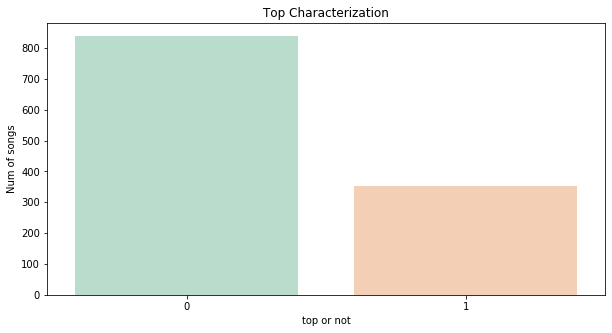

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=df19nondup, x='top',palette="Pastel2")
ax.set(xlabel='top or not', ylabel='Num of songs')
plt.title("Top Characterization")
plt.show()

Accuracy Score: 0.6861924686192469
Recall Score: 0.1267605633802817
Precision Score: 0.4090909090909091


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


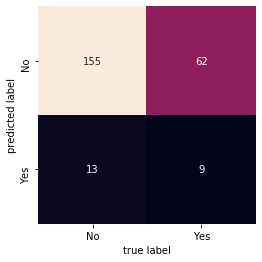

In [20]:
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo']            
X=df19nondup[features]
y=df19nondup['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)

clf= RandomForestClassifier()
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

Accuracy Score: 0.698744769874477
Recall Score: 0.028169014084507043
Precision Score: 0.4


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(2.0, 0.0)

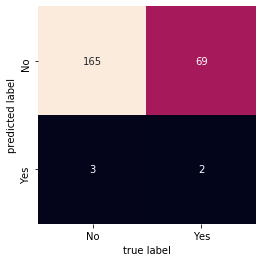

In [21]:
clf = svm.SVC()
clf.fit(X_train, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

df1count  265
df0count  629
df1_over  629
Accuracy Score: 0.5302013422818792
Recall Score: 0.25
Precision Score: 0.22916666666666666


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(2.0, 0.0)

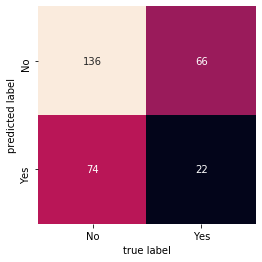

In [22]:
X_train, X_test, y_train, y_test = train_test_split(df19nondup, df19nondup["top"], stratify=df19nondup["top"])
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo']            

# Divide by class
df0 = X_train[X_train['top'] == 0]
df1 = X_train[X_train['top'] == 1]
df1count=df1.shape[0]
df0count=df0.shape[0]
print('df1count ',df1count)
print('df0count ',df0count)
df1_over = df1.sample(df0count, replace=True)
print('df1_over ', df1_over.shape[0])
X_trainb=pd.concat([df1_over, df0], ignore_index=True) #new training Xb balanced
y_train=X_trainb['top']
X_trainb=X_trainb[features]
X_test=X_test[features]
#retry svc
clf = svm.SVC()
clf.fit(X_trainb, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

Accuracy Score: 0.7261904761904762
Recall Score: 0.7380952380952381
Precision Score: 0.7209302325581395


C:\Users\ydi\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


(2.0, 0.0)

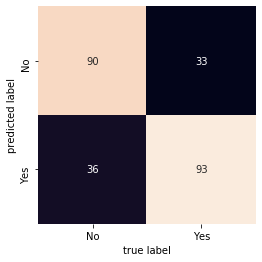

In [23]:
#creating new artificial balanced dataset
df19balanced=pd.concat([df1_over, df0], ignore_index=True)
#resample data
features=['danceability','energy','key','loudness','mode' ,'speechiness','acousticness','instrumentalness','liveness','valence','tempo']            
X=df19balanced[features]
y=df19balanced['top']
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2)
#retry svc
clf = svm.SVC()
clf.fit(X_train, y_train)  

y_pred=clf.predict(X_test)

print("Accuracy Score:",accuracy_score(y_test,y_pred))
print("Recall Score:",recall_score(y_test,y_pred,labels=[1,0]))
print("Precision Score:",precision_score(y_test,y_pred,labels=[1,0]))

mat = confusion_matrix(y_test, y_pred)
s1=sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
          xticklabels=['No','Yes'],
          yticklabels=['No','Yes'] )
plt.xlabel('true label')
plt.ylabel('predicted label')
bottom, top = s1.get_ylim()
s1.set_ylim(bottom + 0.5, top - 0.5)

Looking at features alone seems not to be adequate predict if a given song will reach the top 20 at some point. This sugges